# The Question

The observed maps can be decomposed into four parts theoretically:
$$ X = a S_{\rm CMB} + g_{\nu} y_{\rm sz} + foreground + noise$$
Here $a$ and $g_{\nu}$ are the frequency dependence of the CMB and the SZ effect, which are known.
The foreground is the emission due to the Galaxy, which contaminates to the extraction of CMB and SZ.
The foreground emission varies over the entire sky.
Then, the question is how to deal with this foreground emission.

There are two possible ways:

One is to model it, which is hard. (However, personally, I think it is what we should do. I will discuss it at the end).

Another one is to ignore it, but try to suppress the contamination due to it, as the internal linear combination method does (details are below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
FREQ = [23, 30, 33, 41, 44, 61, 70, 94, 100, 143, 217, 353]
N = len(FREQ)  # Number of frequency

# two components with known frequency dependence
a = np.ones([len(FREQ), 1])  # frequncy dependence of CMB
gnu = np.array([[-5.371, -5.336, -5.291, -5.212, -5.178, -4.933, -4.766, -4.261,
                -4.031, -2.785,  0.187,  6.205]]).T  # frequncy dependence of SZ effect

# For the entire sky, there are 12 maps at different frequencies.
maps = np.load('maps.npy')  # X; observed maps at different frequencies; bad pixels are masked as zero already.
mask = maps[0] == 0  # all good pixels are positive

In [3]:
# covariance matrix and its inverse
R = maps.dot(maps.T)
Rinv = np.linalg.inv(R)
assert np.allclose(Rinv.dot(R), np.eye(N))

# The Internal Linear Combination (ILC) Method

Currently, most extraction of CMB and SZ are based on this method, since it fully uses the prior information $a$ and $g_{\nu}$.

This is not a blind separation method, which completely depends on the known frequency dependence.

$$X = A S$$

A is the mixing matrix, S is the source matrix, and X is the observed maps

Decomposing the A and S leads to 

$$X = a S_{\rm cmb} + g_{\nu} y_{\rm sz} + residuals$$

The residuals are all other terms, including Galactic foreground emission and noises.

The ILC method assumes the uncorrelation for sources, which sounds reasonable, but we will show later that it is not correct.

The ILC tries to find a vector of $w^{\rm T}$, which could extract $\hat{S}_{\rm cmb}$ as 

$$\hat{S}_{\rm cmb} = w^{\rm T} X = w^{\rm T} a S_{\rm cmb} + w^{\rm T} g_{\nu} y_{\rm sz} + w^{\rm T} residuals$$

One will have two constraints here:
$$w^{\rm T} a = 1$$
$$w^{\rm T} g_{\nu} = 0$$
but there are still infinite possible $w^{\rm T}$ satisfing these constraints.

Then, the ILC method tries to minimize the variance of $\hat{S}_{\rm cmb}$ to find the $w^{\rm T}$.
This is because, with the uncorrelation assumption, one will have

$$var(\hat{S}_{\rm cmb}) = var(S_{\rm cmb}) + 0 var(y_{\rm sz}) + var(w^{\rm T} residuals)$$

Thus, minimizing $var(\hat{S}_{\rm cmb})$ means minimizing contamination from other components.

Similarly, one could find another $w^{\rm T}$ for the SZ signal.


In [4]:
# Internal Linear Combination
# https://arxiv.org/abs/1006.5599

aRa = a.T.dot(Rinv).dot(a)
bRb = gnu.T.dot(Rinv).dot(gnu)
aRb = a.T.dot(Rinv).dot(gnu)
bRa = gnu.T.dot(Rinv).dot(a)
aR = a.T.dot(Rinv)
bR = gnu.T.dot(Rinv)
cmb = (bRb*aR.dot(maps) - aRb*bR.dot(maps))/(aRa*bRb - aRb**2)
sz  = (aRa*bR.dot(maps) - bRa*aR.dot(maps))/(bRb*aRa - bRa**2)
cmb = cmb[0]
sz = sz[0]

cmb[mask] = -1
sz[mask] = -1

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


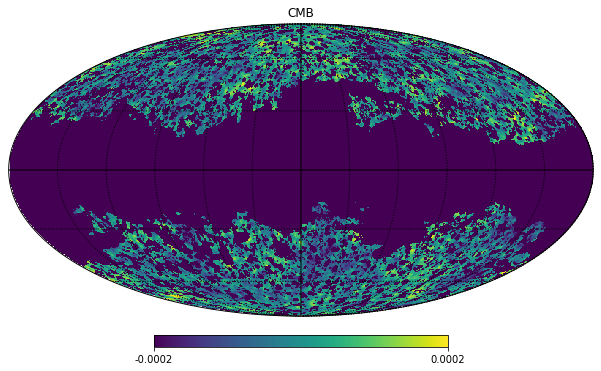

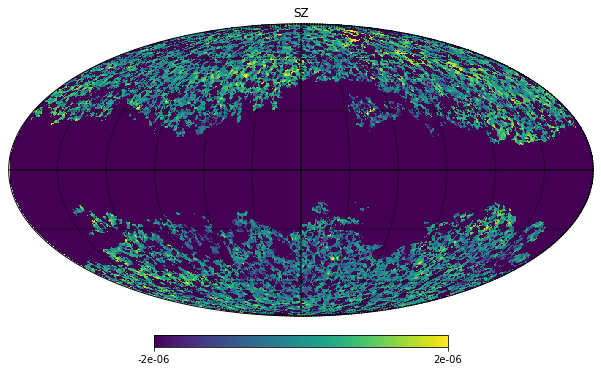

In [5]:
# the extracted CMB and SZ using ILC

hp.mollview(cmb, min=-2e-4, max=2e-4, title='CMB')
hp.graticule()
hp.mollview(sz, min=-2e-6, max=2e-6, title='SZ')
hp.graticule()
# The upper right cornor of the SZ map shows some features unexpected, which is believed
# to be the contamination due to the dust emission.

# The extracted "SZ" map using DMF, also has these features.
# I used the maps (Nchannel * Npixels) here as the input X in DMF,
# but all bad pixels are masked out (not just setting to the zero).
# I used k = 5, and I think -C_hat[:, 3] is the SZ signal.
# C_hat[:, 5] is the CMB signal, while other 3 components are decomposed Galactic foreground.

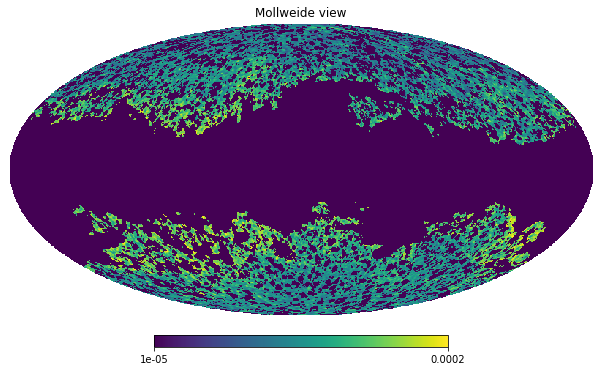

In [6]:
# Subtracting the CMB and SZ components from one of the observed maps as an example.
# The major contributor for the Galactic foreground is the dust emission.

dust = maps[10] - cmb - sz * gnu[10]
dust[mask] = -1
hp.mollview(dust, min=1e-5, max=2e-4)

In [7]:
# check whether the uncorrelation assumption hosts for this extraction.

sz_masked = sz[~mask]
dust_masked = dust[~mask]

# the covariance for the extracted SZ and dust maps.
np.cov(sz_masked, dust_masked)[0, 1]

-2.4469492814537174e-12

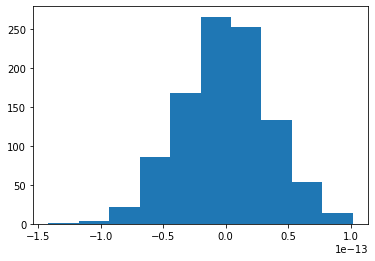

In [8]:
# We randomly shift the order of pixels in the SZ map, which represents
# the case that there is no correlation between SZ and dust.
# It's clear that the extracted map is > 10 sigma away from the random case.

sz_temp = sz_masked.copy()
test_dust_sz = []
for _ in range(1000):
    np.random.shuffle(sz_temp)
    test_dust_sz.append(np.cov(sz_temp, dust_masked)[0, 1])
_ = plt.hist(test_dust_sz)

This correlation between SZ and dust means that the assumption in the ILC does not host in practice.
When one minimizes the variance of $\hat{y}_{\rm sz}$, one actually minimizes
$$var(\hat{y}_{\rm sz}) = var(y_{\rm sz}) + cov(y_{\rm sz}, dust) + var(dust)$$
Then, the covariance term introduces unwanted contamination into the extraction.


# Another Bad Thing
The ILC significantly depends on the frequency dependence of SZ and CMB. This is Okay, if the calibration of the telescopes are well done (i.e., the zero point shift and scale from instrument units to flux).
However, it might not be the case.
Here, we use data from two missions -- Planck (30, 44, 70, 100, and higher frequencies) and WMAP (23, 33, 41, 61, 94).
One could see these two missions are inconsistent with each other, so at least one of them has issues with the calibration.

I am not sure where the extraction method could solve issues like this. Maybe it is just an unsolvable problem.

Text(0, 0.5, 'mean flux')

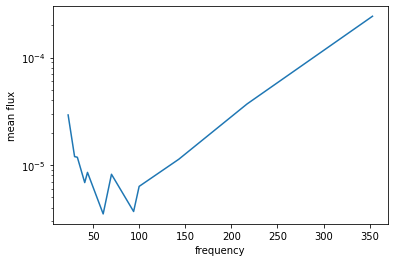

In [9]:
mean_flux = np.mean(maps, axis=1)
plt.plot(FREQ, mean_flux)
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('mean flux')

# One Possible Solution

As we shown above, the currently popular method (ILC only modeling CMB and SZ) assumes the uncorrelation between different sources, which does not host in the extraction.
The break of this assumption leads to dust contamination in the extraction of CMB and SZ.

Following the ILC method, one solution is that we should also model the dust emission in the ILC.
Assuming the Galactic components are
$$residuals = a_{\rm gal1} S_{\rm gal1} + a_{\rm gal2} S_{\rm gal2} + ... + noise$$
one needs more constraints as 
$$w^{\rm T} a_{\rm gal1} = 0$$
$$w^{\rm T} a_{\rm gal2} = 0$$
when extracting CMB or SZ.
With these more constraints, the contamination due to the Galactic foreground is completed eliminated, and the only thing left is the noise.

Therefore, I think one need to extract $a_{\rm gal1}$ and $a_{\rm gal2}$ from the dataset to model the foreground emission.
However, the PCA method does not work in this case, since $a_{\rm gal1}$ and $a_{\rm gal2}$ are definitely not orthogonal to the $a_{\rm cmb}$ and $g_\nu$.
The ICA method might work here, but it is not guaranteed that the Galactic foreground emission is independent from the SZ or CMB signals, which is required by ICA.
I am not sure what is assumed by DMF, but we can talk about it.

# Some Other Thoughts

The variance used in PCA is not a good statistical property.
This is because the noises in the frequency maps have dependence on the mean flux (higher fluxes correspond to higher noises).
From the above plot, the highest frequency map is more than one order magnitude higher than most maps.
In this case, PCA is not good to give the same weight to the variances in different maps, which is equivalent to overestimate the importance of the highest frequency map.

# Summary

My current thought is that we want a semi-blind separation of signals (with knowing $a_{\rm cmb}$ ang $g_\nu$) to model the galactic foreground emission.
Then, with this galactic emission model, one could get rid of the contamination.
However, the tradition methods (as I know) do not work in this case.

I wonder is there any statictical property other than the variance to evaluate the separation.
Also, is it possible for the separation method to consider the zero-shift or scale uncertainty, which is due to the instruments.